In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from enum import Enum
from mpl_toolkits import mplot3d as mp
from scipy.interpolate import RegularGridInterpolator

In [21]:
class OptionType(Enum):
	CALL = 1.0
	PUT = -1.0

def GeneratePathsGBM(NoOfPaths, NoOfSteps, T, r, sigma, S0):
	Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
	X = np.zeros([NoOfPaths, NoOfSteps + 1])
	W = np.zeros([NoOfPaths, NoOfSteps + 1])
	time = np.zeros([NoOfSteps + 1])

	X[:, 0] = np.log(S0)

	dt = T/float(NoOfSteps)

	for i in range(0, NoOfSteps):
		# make sure samples are normal (mu = 0, variance = 1)
		if NoOfPaths > 1:
			Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
		W[:, i + 1] = W[:, i] + np.power(dt, 0.5) * Z[:, i]	
		X[:, i + 1] = X[:, i] + (r - 0.5 * sigma**2) * dt + sigma * (W[:, i + 1] - W[:, i])
		time[i + 1] = time[i] + dt

	# compute exponent of ABM	
	S = np.exp(X)
	paths = {"time": time, "S": S}
	return paths
	


In [22]:
# bsm call price
def BS_CP_Price(CP, S0, K, sigma, t, T, r):
	# print('Maturity T = {0} and t = {1}'.format(T, r))
	# print(float(sigma * np.sqrt(T- t)))
	# print('strike K = {0}'.format(K))
	K = np.array(K).reshape([len(K), 1])
	d1 = (np.log(S0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * (T - t)) / (sigma * np.sqrt(T - t))
	d2 = d1 - sigma * np.sqrt(T - t)
	if CP == OptionType.CALL:
		value = st.norm.cdf(d1) * S0 - st.norm.cdf(d2) * K * np.exp(-r * (T - t))
	elif CP == OptionType.PUT:
		value = st.norm.cdf(-d2) * K * np.exp(-r * (T - t)) - st.norm.cdf(d1) * S0
	return value
	

In [23]:
def BS_Delta(CP, S0, K, sigma, t, T, r):
	K = np.array(K).reshape([len(K), 1])
	d1 = (np.log(S0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * (T - t)) / (sigma * np.sqrt(T - t))
	if CP == OptionType.CALL:
		value = st.norm.cdf(d1)
	elif CP == OptionType.PUT:
		value = st.norm.cdf(d1) - 1
	return value

In [24]:
def BS_Gamma(S0, K, sigma, t, T, r):
	K = np.array(K).reshape([len(K), 1])
	d1 = (np.log(S0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * (T - t)) / (sigma * np.sqrt(T - t))
	return st.norm.pdf(d1) / (S0 * sigma * np.sqrt(T - t))

In [25]:
def BS_Vega(S0, K, sigma, t, T, r):
	K = np.array(K).reshape([len(K), 1])
	d1 = (np.log(S0 / K) + (r + 0.5 * np.power(sigma, 2.0)) * (T - t)) / (sigma * np.sqrt(T - t))
	return S0 * st.norm.pdf(d1) * np.sqrt(T - t)

C:\Users\eorlo\AppData\Local\Temp\ipykernel_6060\3772436491.py:54: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection = '3d')


AttributeError: 'Axes3DSubplot' object has no attribute 'Plot3D'

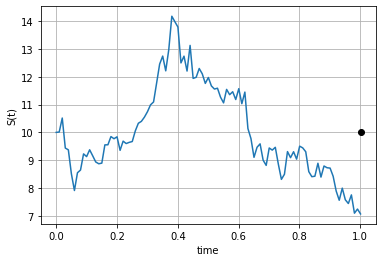

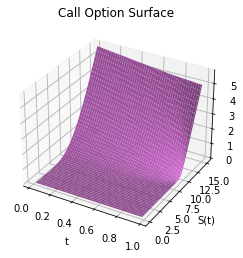

In [27]:
def mainCalc():
	NoOfPaths = 50
	NoofSteps = 100
	T = 1.001
	r = 0.05
	sigma = 0.4
	s0 = 10
	K = [10]
	pathID = 10

	np.random.seed(3)
	Paths = GeneratePathsGBM(NoOfPaths, NoofSteps, T, r, sigma, s0)
	time = Paths["time"]
	S = Paths["S"]

	s0Grid = np.linspace(s0/100.0, 1.5 * s0, 50)
	timeGrid = np.linspace(0.02, T - 0.02, 100)

	CallOpt = lambda t, s0: BS_CP_Price(OptionType.CALL, s0, K, sigma, t, T, r)
	PutOpt = lambda t, s0: BS_CP_Price(OptionType.PUT, s0, K, sigma, t, T, r)
	DeltaCall = lambda t, s0: BS_Delta(OptionType.CALL, s0, K, sigma, t, T, r)
	Gamma = lambda t, s0: BS_Gamma(s0, K, sigma, t, T, r)
	Vega = lambda t, s0: BS_Vega(s0, K, sigma, t, T, r)

	# prep empty matrices for storing results
	callOptM = np.zeros([len(timeGrid), len(s0Grid)])
	putOptM = np.zeros([len(timeGrid), len(s0Grid)])
	deltaCallM = np.zeros([len(timeGrid), len(s0Grid)])
	gammaM = np.zeros([len(timeGrid), len(s0Grid)])
	vegaM = np.zeros([len(timeGrid), len(s0Grid)])
	TM = np.zeros([len(timeGrid), len(s0Grid)])
	s0M = np.zeros([len(timeGrid), len(s0Grid)])

	for i in range(0, len(timeGrid)):
		TM[i, :] = timeGrid[i]
		s0M[i, :] = s0Grid
		callOptM[i, :] = CallOpt(timeGrid[i], s0Grid)
		putOptM[i, :] = PutOpt(timeGrid[i], s0Grid)
		deltaCallM[i, :] = DeltaCall(timeGrid[i], s0Grid)
		gammaM[i, :] = Gamma(timeGrid[i], s0Grid)
		vegaM[i, :] = Vega(timeGrid[i], s0Grid)


	# Plot stock path
	plt.figure(1)
	plt.plot(time, np.squeeze(S[pathID, :]))
	plt.grid()
	plt.xlabel("time")
	plt.ylabel("S(t)")
	plt.plot(T, K, 'ok')

	# plot the call option surface
	fig = plt.figure(2)
	ax = fig.gca(projection = '3d')
	ax.plot_surface(TM, s0M, callOptM, color = [1, 0.5, 1])
	plt.xlabel('t')
	plt.ylabel('S(t)')
	plt.title('Call Option Surface')
	Finterp = RegularGridInterpolator((timeGrid[0:], s0Grid), callOptM)
	v = np.zeros([len(time), 1])
	vTemp = []
	timeTemp = []
	pathTemp = []
	for j in range(5, len(time)):
		if time[j] > timeGrid[0] and time[j] < timeGrid[-1]:
			v[j] = Finterp([time[j], S[pathID, j]])
			vTemp.append(Finterp([time[j], S[pathID, j]])[0])
			timeTemp.append(time[j])
			pathTemp.append(S[pathID, j])


	# add stock path to surface
	ax.Plot3D(np.array(timeTemp), np.array(pathTemp), np.array(vTemp), 'blue')


	# plot the put option surface
	fig = plt.figure(3)
	ax = fig.gca(projection = '3d')
	ax.plot_surface(TM, s0M, putOptM, color = [1, 0.5, 1])
	plt.xlabel('t')
	plt.ylabel('S(t)')
	plt.title('Put Option Surface')
	Finterp = RegularGridInterpolator((timeGrid[0:], s0Grid), callOptM)
	v = np.zeros([len(time), 1])
	vTemp = []
	timeTemp = []
	pathTemp = []
	for j in range(5, len(time)):
		if time[j] > timeGrid[0] and time[j] < timeGrid[-1]:
			v[j] = Finterp([time[j], S[pathID, j]])
			vTemp.append(Finterp([time[j], S[pathID, j]])[0])
			timeTemp.append(time[j])
			pathTemp.append(S[pathID, j])

	ax.Plot3D(np.array(timeTemp), np.array(pathTemp), np.array(vTemp), 'blue')
	ax.view_init(30, 120)


	# plot the put option surface
	fig = plt.figure(4)
	ax = fig.gca(projection = '3d')
	ax.plot_surface(TM, s0M, deltaCallM, color = [1, 0.5, 1])
	plt.xlabel('t')
	plt.ylabel('S(t)')
	plt.title('Delta for a Call Surface')
	Finterp = RegularGridInterpolator((timeGrid[0:], s0Grid), callOptM)
	v = np.zeros([len(time), 1])
	vTemp = []
	timeTemp = []
	pathTemp = []
	for j in range(5, len(time)):
		if time[j] > timeGrid[0] and time[j] < timeGrid[-1]:
			v[j] = Finterp([time[j], S[pathID, j]])
			vTemp.append(Finterp([time[j], S[pathID, j]])[0])
			timeTemp.append(time[j])
			pathTemp.append(S[pathID, j])

	ax.Plot3D(np.array(timeTemp), np.array(pathTemp), np.array(vTemp), 'blue')


	# plot the vega option surface
	fig = plt.figure(5)
	ax = fig.gca(projection = '3d')	
	ax.plot_surface(TM, s0M, vegaM, color = [1, 0.5, 1])
	plt.xlabel('t')
	plt.ylabel('S(t)')
	plt.title('Vega Surface')
	Finterp = RegularGridInterpolator((timeGrid[0:], s0Grid), callOptM)
	v = np.zeros([len(time), 1])
	vTemp = []
	timeTemp = []
	pathTemp = []
	for j in range(5, len(time)):
		if time[j] > timeGrid[0] and time[j] < timeGrid[-1]:
			v[j] = Finterp([time[j], S[pathID, j]])
			vTemp.append(Finterp([time[j], S[pathID, j]])[0])
			timeTemp.append(time[j])
			pathTemp.append(S[pathID, j])

	ax.Plot3D(np.array(timeTemp), np.array(pathTemp), np.array(vTemp), 'blue')
	ax.view_init(30, -120)
		
	# gamma surface
	fig = plt.figure(6)
	ax = fig.gca(projection = '3d')	
	ax.plot_surface(TM, s0M, gammaM, color = [1, 0.5, 1])
	plt.xlabel('t')
	plt.ylabel('S(t)')
	plt.title('Gamma Surface')
	Finterp = RegularGridInterpolator((timeGrid[0:], s0Grid), callOptM)
	v = np.zeros([len(time), 1])
	vTemp = []
	timeTemp = []
	pathTemp = []
	for j in range(5, len(time)):
		if time[j] > timeGrid[0] and time[j] < timeGrid[-1]:
			v[j] = Finterp([time[j], S[pathID, j]])
			vTemp.append(Finterp([time[j], S[pathID, j]])[0])
			timeTemp.append(time[j])
			pathTemp.append(S[pathID, j])

	ax.Plot3D(np.array(timeTemp), np.array(pathTemp), np.array(vTemp), 'blue')
mainCalc()
